In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [2]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [4]:
#GPUチェック
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
# Transformsの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [19]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

In [30]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum().item()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [21]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

In [22]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [23]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [7]:
# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [8]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [15]:
print(type(train_set1[0]))

<class 'tuple'>


In [16]:
#データローダの定義

#ミニバッチのサイズ指定
batch_size = 100

#訓練用データローダ
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

#検証用データローダ
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

#訓練用データローダ
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

#検証用データローダ
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [17]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


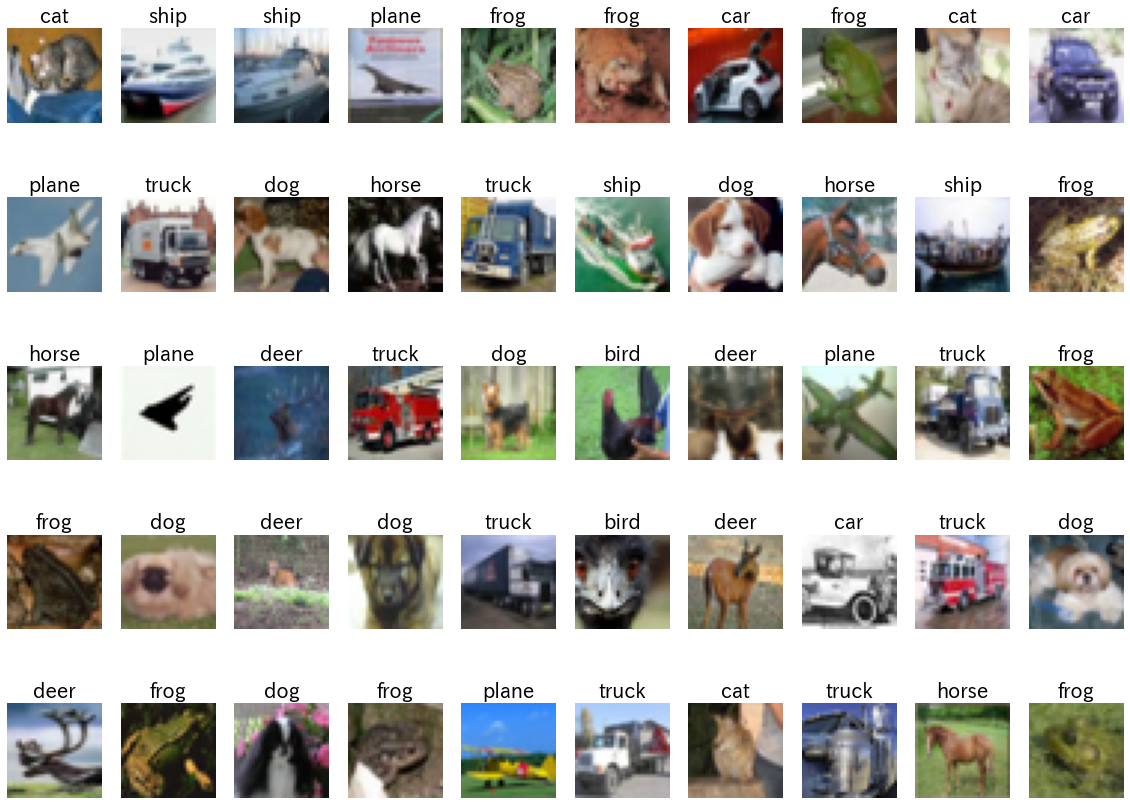

In [24]:

# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

In [25]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [26]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [27]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


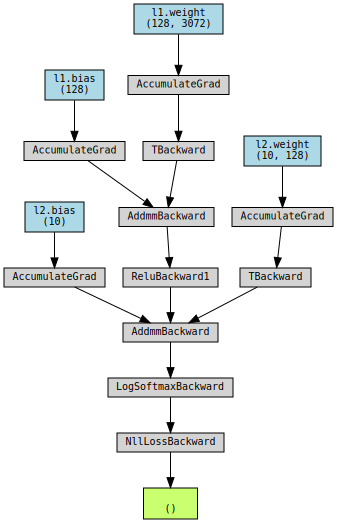

In [28]:
# モデルの概要表示

print(net)
# モデルのサマリー表示

summary(net, (100,3072),depth=1)
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [31]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  1%|          | 6/500 [00:00<00:09, 51.37it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32218 val_loss: 0.01794, val_acc: 0.37710


  1%|          | 6/500 [00:00<00:09, 53.70it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39596 val_loss: 0.01684, val_acc: 0.41810


  1%|          | 6/500 [00:00<00:09, 51.33it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42384 val_loss: 0.01622, val_acc: 0.43910


  1%|          | 6/500 [00:00<00:09, 51.75it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44240 val_loss: 0.01582, val_acc: 0.45080


  1%|          | 6/500 [00:00<00:09, 54.08it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45504 val_loss: 0.01553, val_acc: 0.46120


  1%|          | 6/500 [00:00<00:09, 52.58it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46762 val_loss: 0.01530, val_acc: 0.46860


  1%|          | 6/500 [00:00<00:09, 53.97it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47708 val_loss: 0.01512, val_acc: 0.47380


  1%|          | 5/500 [00:00<00:10, 48.38it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48610 val_loss: 0.01493, val_acc: 0.47740


  1%|          | 6/500 [00:00<00:09, 51.73it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49570 val_loss: 0.01480, val_acc: 0.48700


  1%|          | 6/500 [00:00<00:09, 51.79it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50422 val_loss: 0.01463, val_acc: 0.48880


  1%|          | 6/500 [00:00<00:09, 54.74it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51138 val_loss: 0.01450, val_acc: 0.49500


  1%|          | 6/500 [00:00<00:08, 55.16it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52002 val_loss: 0.01437, val_acc: 0.50220


  1%|          | 5/500 [00:00<00:09, 49.99it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52598 val_loss: 0.01425, val_acc: 0.50450


  1%|          | 6/500 [00:00<00:08, 55.45it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53476 val_loss: 0.01423, val_acc: 0.50580


  1%|          | 6/500 [00:00<00:08, 55.36it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53964 val_loss: 0.01407, val_acc: 0.51450


  1%|          | 6/500 [00:00<00:09, 53.19it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54570 val_loss: 0.01401, val_acc: 0.51160


  1%|          | 6/500 [00:00<00:08, 56.54it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55146 val_loss: 0.01391, val_acc: 0.51380


  1%|          | 5/500 [00:00<00:10, 49.41it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55682 val_loss: 0.01388, val_acc: 0.51420


  1%|          | 6/500 [00:00<00:09, 52.36it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56198 val_loss: 0.01379, val_acc: 0.51980


  1%|          | 6/500 [00:00<00:09, 53.16it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56662 val_loss: 0.01381, val_acc: 0.51770


  1%|          | 6/500 [00:00<00:09, 53.16it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57186 val_loss: 0.01372, val_acc: 0.51820


  1%|          | 6/500 [00:00<00:09, 50.84it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57696 val_loss: 0.01368, val_acc: 0.52330


  1%|          | 5/500 [00:00<00:10, 47.78it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58094 val_loss: 0.01363, val_acc: 0.52500


  1%|          | 6/500 [00:00<00:09, 54.15it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58468 val_loss: 0.01355, val_acc: 0.52600


  1%|          | 5/500 [00:00<00:09, 49.85it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59062 val_loss: 0.01352, val_acc: 0.52790


  1%|          | 6/500 [00:00<00:09, 54.46it/s]

Epoch [26/50], loss: 0.01189 acc: 0.59348 val_loss: 0.01351, val_acc: 0.52800


  1%|          | 6/500 [00:00<00:09, 52.94it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59844 val_loss: 0.01349, val_acc: 0.52580


  1%|          | 6/500 [00:00<00:09, 54.80it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60250 val_loss: 0.01344, val_acc: 0.52940


  1%|          | 6/500 [00:00<00:09, 52.01it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60546 val_loss: 0.01342, val_acc: 0.52850


  1%|          | 5/500 [00:00<00:10, 49.10it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60936 val_loss: 0.01345, val_acc: 0.53130


  1%|          | 6/500 [00:00<00:09, 51.74it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61456 val_loss: 0.01341, val_acc: 0.53080


  1%|          | 6/500 [00:00<00:08, 54.98it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61796 val_loss: 0.01337, val_acc: 0.52960


  1%|          | 6/500 [00:00<00:08, 56.27it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62094 val_loss: 0.01339, val_acc: 0.53110


  1%|          | 6/500 [00:00<00:09, 54.24it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62538 val_loss: 0.01341, val_acc: 0.52900


  1%|          | 5/500 [00:00<00:10, 48.92it/s]

Epoch [35/50], loss: 0.01095 acc: 0.62920 val_loss: 0.01340, val_acc: 0.52580


  1%|          | 5/500 [00:00<00:09, 49.73it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63238 val_loss: 0.01334, val_acc: 0.53280


  1%|          | 5/500 [00:00<00:09, 49.61it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63522 val_loss: 0.01339, val_acc: 0.52820


  1%|          | 6/500 [00:00<00:09, 54.22it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63876 val_loss: 0.01335, val_acc: 0.52930


  1%|          | 6/500 [00:00<00:08, 56.15it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64198 val_loss: 0.01341, val_acc: 0.52970


  1%|          | 5/500 [00:00<00:09, 49.70it/s]

Epoch [40/50], loss: 0.01050 acc: 0.64522 val_loss: 0.01348, val_acc: 0.52390


  1%|          | 6/500 [00:00<00:09, 54.66it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64898 val_loss: 0.01340, val_acc: 0.53060


  1%|          | 6/500 [00:00<00:09, 53.87it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65140 val_loss: 0.01347, val_acc: 0.52810


  1%|          | 6/500 [00:00<00:09, 51.33it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65322 val_loss: 0.01344, val_acc: 0.52490


  1%|          | 6/500 [00:00<00:09, 52.44it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65648 val_loss: 0.01345, val_acc: 0.52840


  1%|          | 6/500 [00:00<00:09, 53.29it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65964 val_loss: 0.01344, val_acc: 0.52660


  1%|          | 5/500 [00:00<00:10, 49.43it/s]

Epoch [46/50], loss: 0.01001 acc: 0.66166 val_loss: 0.01344, val_acc: 0.52930


  1%|          | 6/500 [00:00<00:09, 53.15it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66470 val_loss: 0.01347, val_acc: 0.52650


  1%|          | 6/500 [00:00<00:09, 54.29it/s]

Epoch [48/50], loss: 0.00985 acc: 0.66790 val_loss: 0.01350, val_acc: 0.52930


  1%|          | 6/500 [00:00<00:09, 53.71it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67050 val_loss: 0.01363, val_acc: 0.52020


100%|██████████| 500/500 [00:08<00:00, 56.84it/s]


Epoch [50/50], loss: 0.00970 acc: 0.67214 val_loss: 0.01352, val_acc: 0.53010


初期状態: 損失: 0.01794 精度: 0.37710
最終状態: 損失: 0.01352 精度: 0.53010


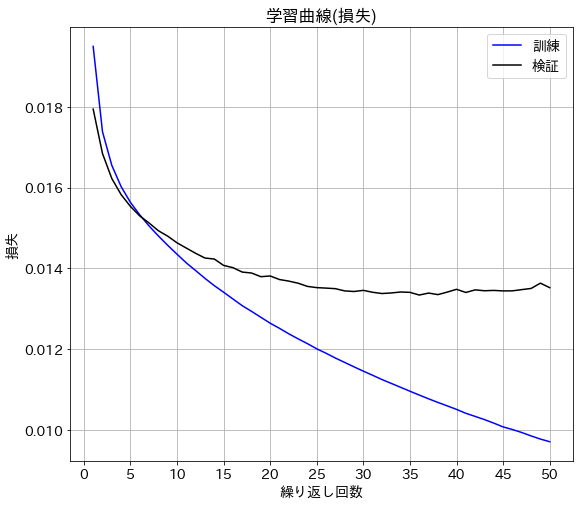

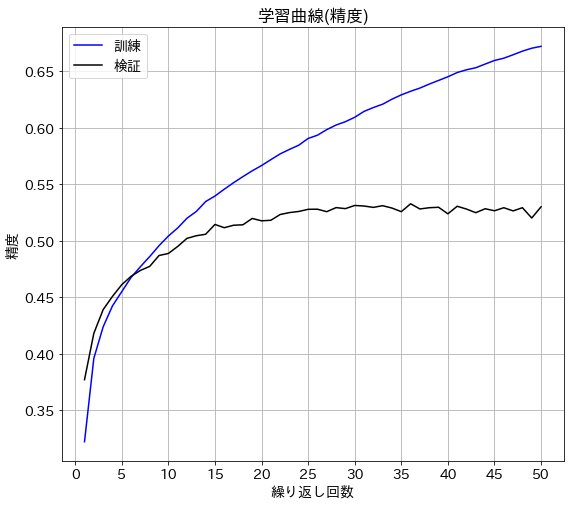

In [32]:
# 評価

evaluate_history(history)

In [41]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3      

In [42]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [43]:
#モデルの表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [45]:

# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable pa

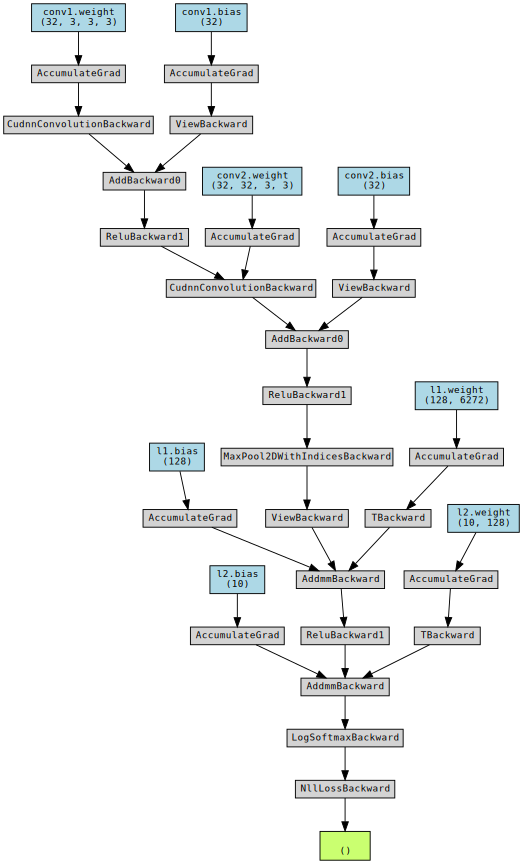

In [44]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [46]:

# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  1%|          | 5/500 [00:00<00:11, 42.56it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26104 val_loss: 0.01866, val_acc: 0.34690


  1%|          | 5/500 [00:00<00:12, 40.54it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37320 val_loss: 0.01677, val_acc: 0.40890


  1%|          | 5/500 [00:00<00:11, 41.27it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43032 val_loss: 0.01530, val_acc: 0.45890


  1%|          | 5/500 [00:00<00:12, 41.01it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47352 val_loss: 0.01451, val_acc: 0.48840


  1%|          | 5/500 [00:00<00:11, 42.78it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49942 val_loss: 0.01370, val_acc: 0.51220


  1%|          | 4/500 [00:00<00:12, 38.93it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52120 val_loss: 0.01332, val_acc: 0.52830


  1%|          | 4/500 [00:00<00:12, 39.70it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53714 val_loss: 0.01293, val_acc: 0.53870


  1%|          | 4/500 [00:00<00:12, 39.34it/s]

Epoch [8/50], loss: 0.01253 acc: 0.55430 val_loss: 0.01254, val_acc: 0.55180


  1%|          | 4/500 [00:00<00:12, 38.27it/s]

Epoch [9/50], loss: 0.01206 acc: 0.57298 val_loss: 0.01235, val_acc: 0.56140


  1%|          | 4/500 [00:00<00:12, 38.39it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59104 val_loss: 0.01185, val_acc: 0.58120


  1%|          | 4/500 [00:00<00:13, 37.44it/s]

Epoch [11/50], loss: 0.01117 acc: 0.60784 val_loss: 0.01165, val_acc: 0.58740


  1%|          | 4/500 [00:00<00:12, 39.80it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62342 val_loss: 0.01174, val_acc: 0.58120


  1%|          | 5/500 [00:00<00:11, 42.64it/s]

Epoch [13/50], loss: 0.01037 acc: 0.63626 val_loss: 0.01112, val_acc: 0.60780


  1%|          | 4/500 [00:00<00:12, 38.29it/s]

Epoch [14/50], loss: 0.00999 acc: 0.65058 val_loss: 0.01091, val_acc: 0.61220


  1%|          | 4/500 [00:00<00:13, 37.94it/s]

Epoch [15/50], loss: 0.00961 acc: 0.66408 val_loss: 0.01111, val_acc: 0.60450


  1%|          | 5/500 [00:00<00:12, 41.18it/s]

Epoch [16/50], loss: 0.00924 acc: 0.67694 val_loss: 0.01057, val_acc: 0.62920


  1%|          | 5/500 [00:00<00:11, 41.54it/s]

Epoch [17/50], loss: 0.00883 acc: 0.69146 val_loss: 0.01064, val_acc: 0.62320


  1%|          | 5/500 [00:00<00:11, 42.01it/s]

Epoch [18/50], loss: 0.00848 acc: 0.70192 val_loss: 0.01013, val_acc: 0.64730


  1%|          | 5/500 [00:00<00:11, 41.35it/s]

Epoch [19/50], loss: 0.00810 acc: 0.71914 val_loss: 0.01016, val_acc: 0.64380


  1%|          | 4/500 [00:00<00:12, 39.52it/s]

Epoch [20/50], loss: 0.00775 acc: 0.72944 val_loss: 0.01043, val_acc: 0.63530


  1%|          | 4/500 [00:00<00:12, 38.54it/s]

Epoch [21/50], loss: 0.00741 acc: 0.74146 val_loss: 0.00999, val_acc: 0.65560


  1%|          | 4/500 [00:00<00:13, 37.10it/s]

Epoch [22/50], loss: 0.00703 acc: 0.75654 val_loss: 0.01017, val_acc: 0.65510


  1%|          | 4/500 [00:00<00:12, 39.63it/s]

Epoch [23/50], loss: 0.00676 acc: 0.76628 val_loss: 0.00989, val_acc: 0.65840


  1%|          | 5/500 [00:00<00:11, 42.41it/s]

Epoch [24/50], loss: 0.00639 acc: 0.77954 val_loss: 0.00999, val_acc: 0.66050


  1%|          | 5/500 [00:00<00:11, 43.14it/s]

Epoch [25/50], loss: 0.00607 acc: 0.79058 val_loss: 0.01001, val_acc: 0.66490


  1%|          | 5/500 [00:00<00:11, 42.76it/s]

Epoch [26/50], loss: 0.00571 acc: 0.80456 val_loss: 0.01042, val_acc: 0.65140


  1%|          | 5/500 [00:00<00:11, 43.39it/s]

Epoch [27/50], loss: 0.00542 acc: 0.81514 val_loss: 0.01063, val_acc: 0.66050


  1%|          | 5/500 [00:00<00:12, 40.84it/s]

Epoch [28/50], loss: 0.00510 acc: 0.82690 val_loss: 0.01122, val_acc: 0.64140


  1%|          | 4/500 [00:00<00:12, 39.58it/s]

Epoch [29/50], loss: 0.00476 acc: 0.83928 val_loss: 0.01051, val_acc: 0.66590


  1%|          | 5/500 [00:00<00:11, 42.00it/s]

Epoch [30/50], loss: 0.00444 acc: 0.85096 val_loss: 0.01110, val_acc: 0.65660


  1%|          | 5/500 [00:00<00:12, 40.99it/s]

Epoch [31/50], loss: 0.00411 acc: 0.86240 val_loss: 0.01090, val_acc: 0.66810


  1%|          | 4/500 [00:00<00:12, 38.73it/s]

Epoch [32/50], loss: 0.00382 acc: 0.87086 val_loss: 0.01151, val_acc: 0.65320


  1%|          | 5/500 [00:00<00:11, 41.28it/s]

Epoch [33/50], loss: 0.00355 acc: 0.88158 val_loss: 0.01123, val_acc: 0.66720


  1%|          | 5/500 [00:00<00:11, 42.79it/s]

Epoch [34/50], loss: 0.00325 acc: 0.89198 val_loss: 0.01246, val_acc: 0.64640


  1%|          | 5/500 [00:00<00:11, 42.35it/s]

Epoch [35/50], loss: 0.00297 acc: 0.90328 val_loss: 0.01287, val_acc: 0.64710


  1%|          | 5/500 [00:00<00:11, 42.90it/s]

Epoch [36/50], loss: 0.00271 acc: 0.91266 val_loss: 0.01304, val_acc: 0.64960


  1%|          | 5/500 [00:00<00:11, 41.67it/s]

Epoch [37/50], loss: 0.00240 acc: 0.92498 val_loss: 0.01270, val_acc: 0.66610


  1%|          | 5/500 [00:00<00:11, 42.42it/s]

Epoch [38/50], loss: 0.00216 acc: 0.93310 val_loss: 0.01312, val_acc: 0.65920


  1%|          | 5/500 [00:00<00:11, 43.02it/s]

Epoch [39/50], loss: 0.00194 acc: 0.94172 val_loss: 0.01368, val_acc: 0.65990


  1%|          | 4/500 [00:00<00:12, 38.16it/s]

Epoch [40/50], loss: 0.00176 acc: 0.95122 val_loss: 0.01432, val_acc: 0.65710


  1%|          | 5/500 [00:00<00:11, 41.49it/s]

Epoch [41/50], loss: 0.00146 acc: 0.95942 val_loss: 0.01531, val_acc: 0.65690


  1%|          | 4/500 [00:00<00:12, 38.35it/s]

Epoch [42/50], loss: 0.00128 acc: 0.96596 val_loss: 0.01531, val_acc: 0.65220


  1%|          | 5/500 [00:00<00:11, 42.49it/s]

Epoch [43/50], loss: 0.00107 acc: 0.97412 val_loss: 0.01550, val_acc: 0.65810


  1%|          | 5/500 [00:00<00:11, 41.39it/s]

Epoch [44/50], loss: 0.00104 acc: 0.97534 val_loss: 0.01586, val_acc: 0.66050


  1%|          | 4/500 [00:00<00:13, 38.10it/s]

Epoch [45/50], loss: 0.00076 acc: 0.98532 val_loss: 0.01651, val_acc: 0.66150


  1%|          | 4/500 [00:00<00:12, 40.00it/s]

Epoch [46/50], loss: 0.00061 acc: 0.99018 val_loss: 0.01706, val_acc: 0.66310


  1%|          | 4/500 [00:00<00:13, 37.99it/s]

Epoch [47/50], loss: 0.00051 acc: 0.99224 val_loss: 0.01729, val_acc: 0.66440


  1%|          | 4/500 [00:00<00:12, 39.32it/s]

Epoch [48/50], loss: 0.00038 acc: 0.99616 val_loss: 0.01775, val_acc: 0.66310


  1%|          | 5/500 [00:00<00:11, 42.07it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99792 val_loss: 0.01852, val_acc: 0.66290


100%|██████████| 500/500 [00:11<00:00, 43.77it/s]


Epoch [50/50], loss: 0.00024 acc: 0.99858 val_loss: 0.01881, val_acc: 0.66190


初期状態: 損失: 0.01866 精度: 0.34690
最終状態: 損失: 0.01881 精度: 0.66190


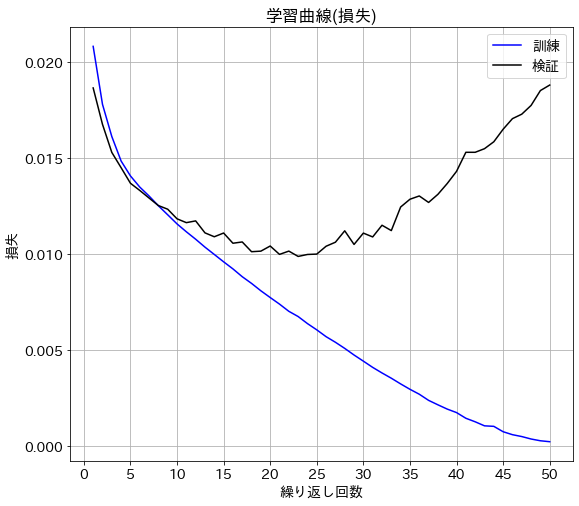

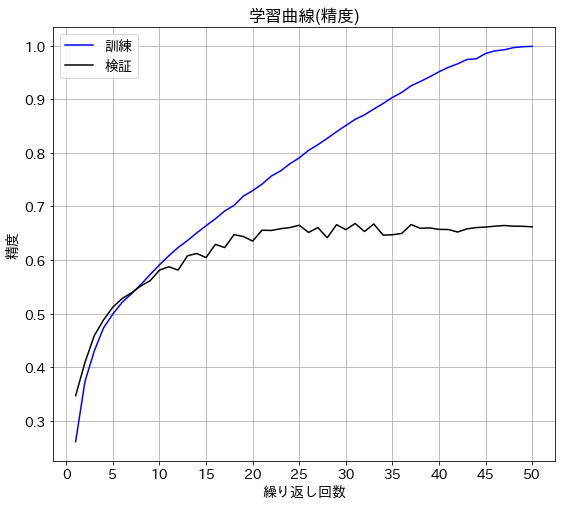

In [47]:
# 評価

evaluate_history(history2)

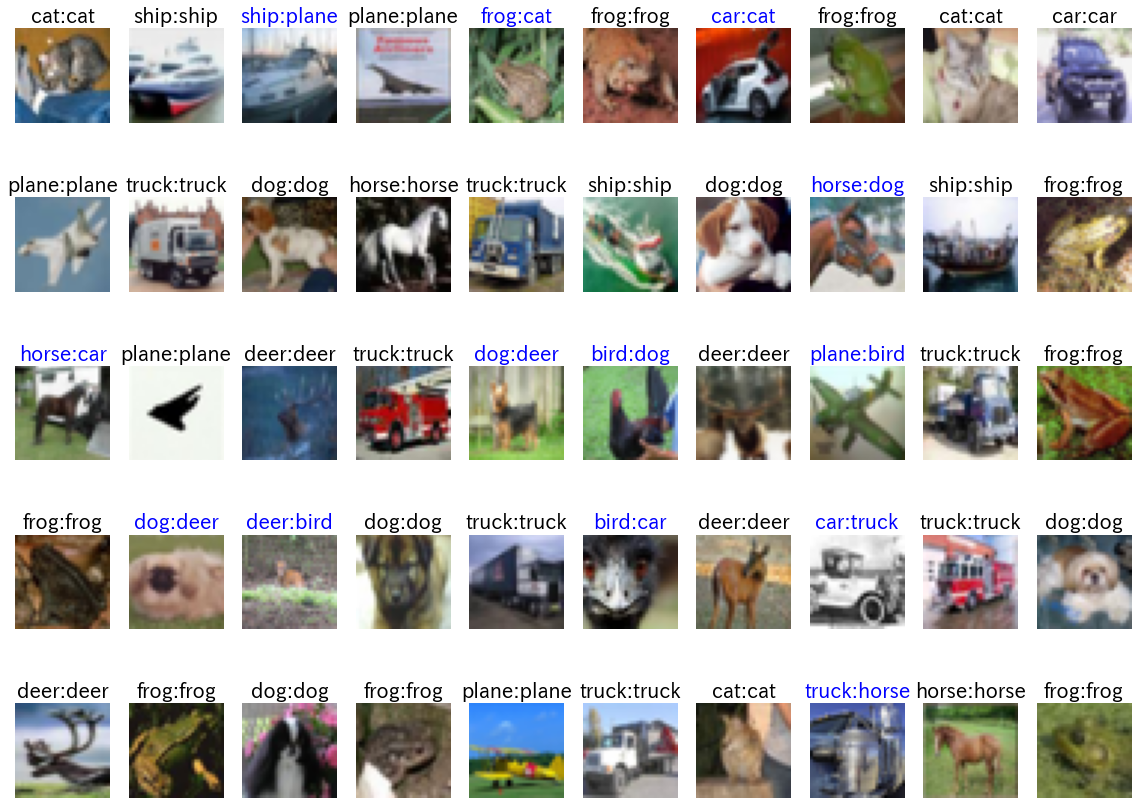

In [48]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)